<a href="https://colab.research.google.com/github/lele25811/Vehicle-ReId/blob/main/Vehicle_ReId_Rete_Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vehicle Re-Id tramite Rete Siamese

* dataset: vehicle-776
* model:

#1. Download datasets

In [1]:
# Monto il mio google drive (una volta montanto il contenuto di google drive sarà accessibile nella directory `/content/drive/My Drive`)
from google.colab import drive
!mkdir -p drive/
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Indoviduo il path del dataset
dataset_path = "/content/drive/MyDrive/datasets/VeRi.zip"

In [3]:
# Creo la cartella `data`
!mkdir -p data/

In [4]:
# Copio il file nel Workspace
!cp "/content/drive/MyDrive/datasets/VeRi.zip" /content/

In [5]:
# Controllo il tipo di file scaricato
!file VeRi.zip

VeRi.zip: Zip archive data, at least v1.0 to extract, compression method=store


In [6]:
# Decomprimo il file zip
!unzip -q /content/VeRi.zip -d data

# Organizzazione Dataset
1. Parsing del file XML

Estraiamo le informazioni rilevanti dal file XML e le memorizziamo in un DataFrame Pandas

    train_labels_df
    test_labels_df

che contengono:

    nome immagine
    Vehicle ID
    Camera ID
    Color ID
    Type ID



In [7]:
import xml.etree.ElementTree as ET
import pandas as pd

def parse_labels(label_path):
    # Lista per memorizzare i dati
    data = []

    # Aprire il file con la codifica esplicita
    with open(label_path, "r", encoding="ascii", errors="ignore") as f:
      content = f.read() # Leggi il contenuto ignorando gli errori

      try:
        tree = ET.ElementTree(ET.fromstring(content))  # Parso direttamente il contenuto
        root = tree.getroot()  # Ottieni il nodo radice
        # Iterare attraverso i nodi Item
        for item in root.find('Items').findall("Item"):
          image_name = item.get("imageName")
          vehicle_id = item.get("vehicleID")
          camera_id = item.get("cameraID")
          color_id = item.get("colorID")
          type_id = item.get("typeID")

          # Aggiungere i dati alla lista
          data.append({
            "image_name": image_name,
            "vehicle_id": int(vehicle_id),
            "camera_id": camera_id,
            "color_id": int(color_id),
            "type_id": int(type_id)
          })
      except ET.ParseError as e:
        print(f"Errore di parsing: {e}")
        return {}

    return pd.DataFrame(data)

# Percorso al file XML
train_label_path = "/content/data/VeRi/train_label.xml"
test_label_path = "/content/data/VeRi/test_label.xml"

# Creo un dataframe per le immagini di train e test
train_labels_df = parse_labels(train_label_path)
test_labels_df = parse_labels(test_label_path)

# Recupero le dimensioni dei dataset (righe e colonne)
train_df_rows, train_df_cols = train_labels_df.shape
test_df_rows, test_df_cols = test_labels_df.shape

print(f"train dataframe -> rows: {train_df_rows}, cols: {train_df_cols}")
print(f"test dataframe -> rows: {test_df_rows}, cols: {test_df_cols}")

train dataframe -> rows: 37746, cols: 5
test dataframe -> rows: 11579, cols: 5


In [8]:
# Controlliamo i primi elementi per confermare che le colonne siano riempite correttamente
print(train_labels_df.head())
print(test_labels_df.head())

                 image_name  vehicle_id camera_id  color_id  type_id
0  0001_c001_00016450_0.jpg           1      c001         1        4
1  0001_c001_00016460_0.jpg           1      c001         1        4
2  0001_c001_00016470_0.jpg           1      c001         1        4
3  0001_c001_00016480_0.jpg           1      c001         1        4
4  0001_c001_00016490_0.jpg           1      c001         1        4
                 image_name  vehicle_id camera_id  color_id  type_id
0  0002_c002_00030600_0.jpg           2      c002         1        4
1  0002_c002_00030605_1.jpg           2      c002         1        4
2  0002_c002_00030615_1.jpg           2      c002         1        4
3  0002_c002_00030625_1.jpg           2      c002         1        4
4  0002_c002_00030640_0.jpg           2      c002         1        4


In [9]:
# Controlliamo che non ci siano valori nulli (stampa quanti NULL ci sono)
print(train_labels_df.isnull().sum())
print(test_labels_df.isnull().sum())

image_name    0
vehicle_id    0
camera_id     0
color_id      0
type_id       0
dtype: int64
image_name    0
vehicle_id    0
camera_id     0
color_id      0
type_id       0
dtype: int64


In [10]:
print("Color ID unici:", train_labels_df["color_id"].nunique())
print("Type ID unici:", train_labels_df["type_id"].nunique())

Color ID unici: 10
Type ID unici: 9


# 2. Creazione e gestione delle coppie per la rete siamese
Devo creare coppie di immagini (chiamate positive e negative) per la rete siamese:
* Coppie positive: Immagini dello stesso veicolo (stesso id_veicolo).
* Coppie negative: Immagini di veicoli diversi (differenti id_veicolo).



Descrizione funzionamento:
* Coppie Positive:

    Per ogni vehicle_id, raccogli tutte le immagini associate.
    Genera combinazioni uniche di immagini appartenenti allo stesso veicolo (images_same_vehicle).

* Coppie Negative:

    Per ogni immagine, seleziona casualmente un'altra immagine da un veicolo diverso (negative_vehicle_id).
    Ripeti questo processo per un numero configurabile di coppie negative (controllato da num_negative_pairs).

* Output:

    Ogni coppia è una tupla del tipo (img1, img2, label), dove label è 1 per coppie positive e 0 per negative.

In [11]:
import pandas as pd
import random

def create_pairs_from_dataframe(dataframe, num_negative_pairs=1):
    """
    Genera coppie positive e negative da un dataframe di immagini.

    Args:
        dataframe (pd.DataFrame): Contiene colonne ['nome_image', 'vehicle_id', 'camera_id', 'color_id', 'type_id'].
        num_negative_pairs (int): Numero di coppie negative da creare per ogni coppia positiva.

    Returns:
        List[Tuple]: Lista di tuple (img1, img2, label), dove label è 1 per coppie positive e 0 per negative.
    """
    # Organizza i dati per vehicle_id
    data_by_id = dataframe.groupby('vehicle_id')
    unique_ids = dataframe['vehicle_id'].unique()

    pairs = []

    for vehicle_id in unique_ids:
        # Estrai tutte le immagini per lo stesso vehicle_id
        images_same_vehicle = data_by_id.get_group(vehicle_id)['image_name'].values

        # Genera coppie positive
        for i in range(len(images_same_vehicle)):
            for j in range(i + 1, len(images_same_vehicle)):
                pairs.append((images_same_vehicle[i], images_same_vehicle[j], 1))  # Label = 1 (positive)

        # Genera coppie negative
        other_ids = [vid for vid in unique_ids if vid != vehicle_id]
        for _ in range(num_negative_pairs * len(images_same_vehicle)):
            # Scegli un'immagine casuale dallo stesso vehicle_id
            img1 = random.choice(images_same_vehicle)
            # Scegli un'immagine casuale da un altro vehicle_id
            negative_vehicle_id = random.choice(other_ids)
            img2 = data_by_id.get_group(negative_vehicle_id)['image_name'].sample().iloc[0]
            pairs.append((img1, img2, 0))  # Label = 0 (negative)

    return pairs

train_pairs = create_pairs_from_dataframe(train_labels_df, num_negative_pairs=1)
test_pairs = create_pairs_from_dataframe(test_labels_df, num_negative_pairs=1)

# Stampa alcune coppie generate
print("Train pairs example:", train_pairs[:5])
print("Test pairs example:", test_pairs[:5])


Train pairs example: [('0001_c001_00016450_0.jpg', '0001_c001_00016460_0.jpg', 1), ('0001_c001_00016450_0.jpg', '0001_c001_00016470_0.jpg', 1), ('0001_c001_00016450_0.jpg', '0001_c001_00016480_0.jpg', 1), ('0001_c001_00016450_0.jpg', '0001_c001_00016490_0.jpg', 1), ('0001_c001_00016450_0.jpg', '0001_c001_00016500_0.jpg', 1)]
Test pairs example: [('0002_c002_00030600_0.jpg', '0002_c002_00030605_1.jpg', 1), ('0002_c002_00030600_0.jpg', '0002_c002_00030615_1.jpg', 1), ('0002_c002_00030600_0.jpg', '0002_c002_00030625_1.jpg', 1), ('0002_c002_00030600_0.jpg', '0002_c002_00030640_0.jpg', 1), ('0002_c002_00030600_0.jpg', '0002_c002_00030670_0.jpg', 1)]


In [12]:
import torch
from PIL import Image
import os

La classe `SiamesePairDataset` è un'estensione della classe Datasets di PyTorch.
E progettata per lavorare con un modello siamese e gestire coppie di immagini e le loro etichette.

In [13]:
from torch.utils.data import Dataset

class SiamesePairDataset(Dataset):
    def __init__(self, pairs, image_dir, transform=None):
        """
        Dataset per coppie siamese.

        Args:
            pairs (list): Lista di tuple (img1, img2, label).
            image_dir (str): Directory delle immagini.
            transform (callable, optional): Trasformazioni per le immagini.
        """
        self.pairs = pairs
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_name, img2_name, label = self.pairs[idx]
        img1_path = os.path.join(self.image_dir, img1_name)
        img2_path = os.path.join(self.image_dir, img2_name)

        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

In [14]:
from torchvision import transforms

# Trasformazioni per l'allenamento e il test
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  # Converte l'immagine in tensore
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalizzazione ImageNet
])

In [15]:
from torch.utils.data import DataLoader

# Configura il DataLoader
train_dataset = SiamesePairDataset(train_pairs, image_dir='/content/data/VeRi/image_train', transform=transform)
test_dataset = SiamesePairDataset(test_pairs, image_dir='/content/data/VeRi/image_test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Esegui il training con il modello e la funzione di perdita definiti precedentemente.

# 3. Definizione del modello
Il modello `LightSiameseNetwork` è una rete siaamese progettata per essere leggera, adatta a compiti come il confronto tra coppie di immagini, questa rete convoluzionale (**CNN**) estrae rappresentazioni compatte da un'immagine.
Struttura:
1. *Estrattore di Caratteristiche*:
* **Conv2D**: Filtri convoluzionali per estrarre caratteristiche spaziali.
* **ReLU**: Funzione di attivazione non lineare.
* **MaxPool2D**: Riduce le dimensioni spaziali dimezzandole.
* **AdaptiveAvgPool2D**: Riduce ulteriormente la rappresentazione spaziale a un vettore di dimensione fissa (64, 1, 1).
* **Flatten**: Converte il risultato finale in un vettore piatto di dimensione (batch_size, 64).
2. *Proiezione nello spazio degli Embedding*:
Questo blocco prende il vettore di caratteristiche prodotto dall'estrattore (feature_extractor) e lo trasforma in un embedding, cioè una rappresentazione compatta e discriminativa dell'immagine.
* **Linear**(64, embedding_dim): strato di trasformazione lineare che mappa il vettore in input(dimensione 64) in uno spazio di dimensione `embedding_dim` con lo scopo di mappare il vettore in uno spazio dove le relazioni di similarità siano più evidenti.
* **ReLU**: Funzione di attivazione non lineare.
* **Linear**: altro strato lineare che agisce come una raffinazione o trasformazione finale dell'embedding.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LightSiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=64):
        super(LightSiameseNetwork, self).__init__()

        # Feature extractor semplice e leggero
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # (C=16, H, W)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (C=16, H/2, W/2)
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (C=32, H/2, W/2)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (C=32, H/4, W/4)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (C=64, H/4, W/4)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),  # Output: (64, 1, 1)
            nn.Flatten()  # Output: (batch_size, 64)
        )

        # Proiezione nello spazio degli embedding
        self.fc = nn.Sequential(
            nn.Linear(64, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )

    def forward_once(self, x):
        """
        Esegue una forward pass per una singola immagine.
        """
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        """
        Forward pass per due immagini.
        """
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


**Funzione di perdita** comunemente utilizzata nelle reti siamese, questa funzione di perdita aiuta il modelle a imparare a ridurre la distanza tra coppie di immagini simili (positve) e ad aumentare la distanza tra coppie di immagini dissimili (negative) fino a un margine predefinito.

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        """
        Inizializza la Contrastive Loss con il margine dato.

        Args:
            margin (float): Margine per coppie negative.
        """
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, emb1, emb2, label):
        """
        Calcola la Contrastive Loss.

        Args:
            emb1 (Tensor): Embedding della prima immagine (batch_size, embedding_dim).
            emb2 (Tensor): Embedding della seconda immagine (batch_size, embedding_dim).
            label (Tensor): Label binaria (1 per positivo, 0 per negativo).

        Returns:
            Tensor: Valore della loss.
        """
        # Distanza euclidea tra gli embedding
        distance = F.pairwise_distance(emb1, emb2)

        # Loss per coppie positive (label=1) e negative (label=0)
        positive_loss = label * (distance ** 2)
        negative_loss = (1 - label) * F.relu(self.margin - distance) ** 2

        # Loss totale (media del batch)
        loss = 0.5 * (positive_loss + negative_loss).mean()
        return loss


#4. Train & Eval loop

In [18]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm  # Importa tqdm per il monitoraggio

# Configurazione del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizzando dispositivo: {device}")

# Modello, perdita e ottimizzatore
model = LightSiameseNetwork(embedding_dim=64).to(device)
criterion = ContrastiveLoss(margin=1.0)  # Margin per la Contrastive Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Loop di allenamento
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Itera sul train_loader con tqdm
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for img1, img2, label in train_loader_tqdm:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        # Forward pass
        emb1, emb2 = model(img1, img2)
        loss = criterion(emb1, emb2, label)

        # Backward pass e aggiornamento
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Aggiorna la descrizione del progresso
        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Valutazione ogni epoca
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        # Itera sul test_loader con tqdm
        test_loader_tqdm = tqdm(test_loader, desc=f"Valutazione Epoch {epoch+1}", unit="batch")
        for img1, img2, label in test_loader_tqdm:
            img1, img2 = img1.to(device), img2.to(device)
            label = label.to(device)

            # Embedding e predizione
            emb1, emb2 = model(img1, img2)
            distance = torch.nn.functional.pairwise_distance(emb1, emb2)
            predictions = (distance < 0.5).float()  # Soglia di 0.5 per predire "stesso veicolo"
            correct += (predictions == label).sum().item()
            total += label.size(0)

    accuracy = correct / total
    print(f"Accuracy dopo epoch {epoch+1}: {accuracy:.4f}")


Utilizzando dispositivo: cuda


Epoch 1/1: 100%|██████████| 6816/6816 [1:35:39<00:00,  1.19batch/s, loss=0.00625]


Epoch [1/1], Loss: 0.0091


Valutazione Epoch 1: 100%|██████████| 1792/1792 [23:51<00:00,  1.25batch/s]

Accuracy dopo epoch 1: 0.9768


In [22]:
import matplotlib.pyplot as plt
from PIL import Image

def find_and_visualize_best_match_once(query_image_path, reference_image_paths, model, transform, device='cpu'):
    """
    Trova l'immagine più simile a una query e visualizza tutte le immagini di riferimento,
    colorando di verde l'immagine più simile.

    Args:
        query_image_path (str): Percorso dell'immagine di query.
        reference_image_paths (list): Lista di percorsi delle immagini di riferimento.
        model (torch.nn.Module): Modello Siamese addestrato.
        transform (callable): Trasformazioni per preprocessare le immagini.
        device (str): Dispositivo per l'elaborazione ('cpu' o 'cuda').

    Returns:
        tuple: (Percorso dell'immagine più simile, distanza minima).
    """
    import torch
    import torch.nn.functional as F

    # Preprocessa l'immagine di query
    query_image = Image.open(query_image_path).convert('RGB')
    query_tensor = transform(query_image).unsqueeze(0).to(device)

    # Calcola l'embedding per l'immagine di query
    model.eval()
    with torch.no_grad():
        query_embedding = model.forward_once(query_tensor)

    # Inizializza la ricerca
    distances = []

    # Confronta l'embedding della query con ogni immagine di riferimento
    for ref_path in reference_image_paths:
        ref_image = Image.open(ref_path).convert('RGB')
        ref_tensor = transform(ref_image).unsqueeze(0).to(device)

        with torch.no_grad():
            ref_embedding = model.forward_once(ref_tensor)

        # Calcola la distanza tra gli embedding
        distance = F.pairwise_distance(query_embedding, ref_embedding).item()
        distances.append((ref_path, ref_image, distance))

    # Ordina per distanza crescente
    distances.sort(key=lambda x: x[2])
    most_similar_path, most_similar_image, min_distance = distances[0]

    # Visualizzazione
    fig, axes = plt.subplots(1, len(reference_image_paths) + 1, figsize=(15, 5))

    # Immagine di query
    axes[0].imshow(query_image)
    axes[0].axis('off')
    axes[0].set_title("Query Image")

    # Visualizza immagini di riferimento
    for idx, (ref_path, ref_image, distance) in enumerate(distances, start=1):
        axes[idx].imshow(ref_image)
        axes[idx].axis('off')

        # Colore della cornice
        color = 'green' if ref_path == most_similar_path else 'red'
        axes[idx].set_title(f"Dist: {distance:.4f}", color=color)

    plt.tight_layout()
    plt.show()

    return most_similar_path, min_distance


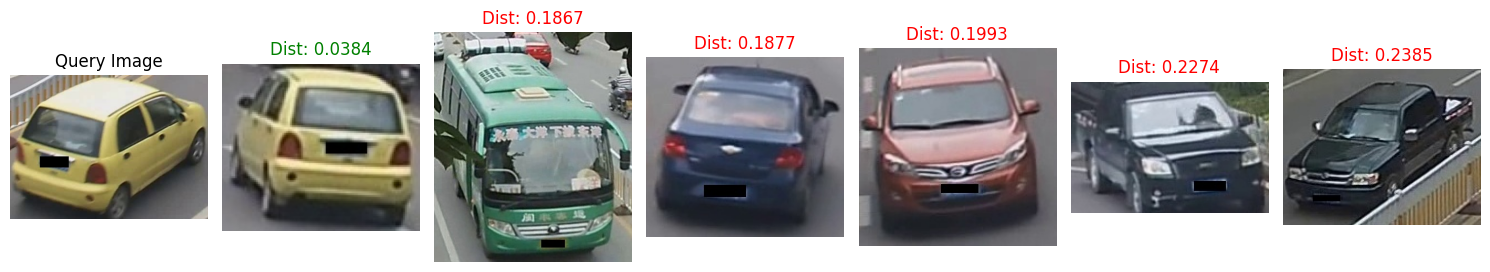

L'immagine più simile è: /content/data/VeRi/image_test/0002_c002_00030670_0.jpg con una distanza di: 0.0384


In [23]:
import os

# Percorsi
query_image = "/content/data/VeRi/image_query/0002_c002_00030600_0.jpg"
reference_images = ["/content/data/VeRi/image_test/0102_c012_00007875_0.jpg",
                    "/content/data/VeRi/image_test/0002_c002_00030670_0.jpg",
                    "/content/data/VeRi/image_test/0006_c019_00024125_0.jpg",
                    "/content/data/VeRi/image_test/0090_c009_00078235_0.jpg",
                    "/content/data/VeRi/image_test/0042_c002_00085830_0.jpg",
                    "/content/data/VeRi/image_test/0065_c016_00068360_0.jpg"]

# Dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# Esegui la ricerca
most_similar_image, distance = find_and_visualize_best_match_once(query_image, reference_images, model, transform, device)

# Risultato
print(f"L'immagine più simile è: {most_similar_image} con una distanza di: {distance:.4f}")


In [24]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F

def find_and_visualize_best_match(query_image_path, reference_image_paths, model, transform, device='cpu'):
    """
    Trova l'immagine più simile a una query e visualizza tutte le immagini di riferimento,
    colorando di verde l'immagine più simile.

    Args:
        query_image_path (str): Percorso dell'immagine di query.
        reference_image_paths (list): Lista di percorsi delle immagini di riferimento.
        model (torch.nn.Module): Modello Siamese addestrato.
        transform (callable): Trasformazioni per preprocessare le immagini.
        device (str): Dispositivo per l'elaborazione ('cpu' o 'cuda').

    Returns:
        tuple: (Percorso dell'immagine più simile, distanza minima).
    """
    # Preprocessa l'immagine di query
    query_image = Image.open(query_image_path).convert('RGB')
    query_tensor = transform(query_image).unsqueeze(0).to(device)

    # Inizializza la ricerca
    distances = []

    # Confronta l'immagine di query con ogni immagine di riferimento
    model.eval()
    for ref_path in reference_image_paths:
        ref_image = Image.open(ref_path).convert('RGB')
        ref_tensor = transform(ref_image).unsqueeze(0).to(device)

        with torch.no_grad():
            # Calcola gli embedding usando il forward completo
            query_embedding, ref_embedding = model(query_tensor, ref_tensor)

        # Calcola la distanza tra gli embedding
        distance = F.pairwise_distance(query_embedding, ref_embedding).item()
        distances.append((ref_path, ref_image, distance))

    # Ordina per distanza crescente
    distances.sort(key=lambda x: x[2])
    most_similar_path, most_similar_image, min_distance = distances[0]

    # Visualizzazione
    fig, axes = plt.subplots(1, len(reference_image_paths) + 1, figsize=(15, 5))

    # Immagine di query
    axes[0].imshow(query_image)
    axes[0].axis('off')
    axes[0].set_title("Query Image")

    # Visualizza immagini di riferimento
    for idx, (ref_path, ref_image, distance) in enumerate(distances, start=1):
        axes[idx].imshow(ref_image)
        axes[idx].axis('off')

        # Colore della cornice
        color = 'green' if ref_path == most_similar_path else 'red'
        axes[idx].set_title(f"Dist: {distance:.4f}", color=color)

    plt.tight_layout()
    plt.show()

    return most_similar_path, min_distance

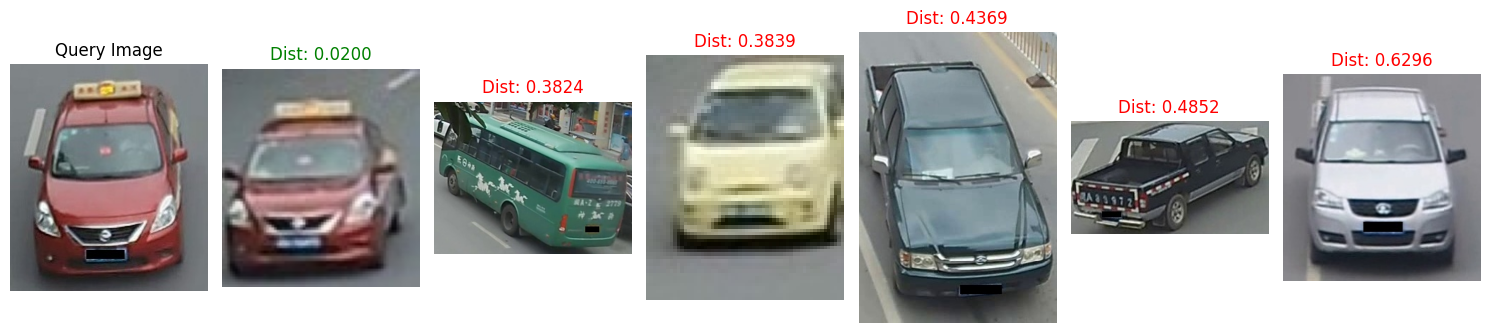

L'immagine più simile è: /content/data/VeRi/image_test/0035_c006_00001085_1.jpg con una distanza di: 0.0200


In [26]:
# Percorsi
query_image = "/content/data/VeRi/image_query/0035_c006_00001150_0.jpg"
reference_images = ["/content/data/VeRi/image_test/0002_c006_00083490_0.jpg",
                    "/content/data/VeRi/image_test/0066_c016_00055465_0.jpg",
                    "/content/data/VeRi/image_test/0035_c006_00001085_1.jpg",
                    "/content/data/VeRi/image_test/0086_c013_00079890_0.jpg",
                    "/content/data/VeRi/image_test/0102_c016_00010770_0.jpg",
                    "/content/data/VeRi/image_test/0101_c001_00043710_0.jpg"]

# Dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# Esegui la ricerca
most_similar_image, distance = find_and_visualize_best_match(query_image, reference_images, model, transform, device)

# Risultato
print(f"L'immagine più simile è: {most_similar_image} con una distanza di: {distance:.4f}")